## Jupyter Notebook: Code for extracting and processing Zygo/MetroPro data files
### Simulating bonds between surface maps, auto-comparison of possible bonded pairs
##### Scott Gallacher (2315629), 2020/2021

In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as Rot  # - performing rotations of vectors
import scipy.optimize
import scipy.ndimage  # - performing rotation of array as image - i.e. around z-axis
import copy  # - copy a python object
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # - get unique colour maps
from itertools import combinations  # - get all N-length combinations from a list
from scipy.interpolate import griddata  # - possible interpolation function to fit new x,y positions to original x,y of grid
# %matplotlib notebook  # - to make plots interactive

In [2]:
# - 1x class: "zygomap(filename=None, array=None, map1=None, map2=None, angle=None)"
# - 2(+)x functions to work with pairs of maps:
# - - - "combinemaps(lowermap,uppermap,optimised=True,output=True)" - lowermap,uppermap are zygomap objects
# --------- combinemaps uses ztestf() so this is also a distinct function, while testf() (for flattening) can be a class method
# --------- could be defined within combinemaps (?) as it's only used there
# - - - "matchdims(map1,map2)" - map1,map2 are MxN arrays (used from within combinemaps(), using map.heights array)
# - - - (possible addition) - to simulate realistic contacts of surfaces when combined (e.g. find 3 points) (would be used by combinemaps())
# - - - "comparebonds" - to simulate interface (bond) of each combination of available maps, display lowest PV & RMS heights
# - - - "rotatepoints" - general rotation function made, but has no real use for zygomaps as each rotation method has unique needs

In [114]:
class zygomap:
    #structure: definition of methods for the class (to perform operations on the zygomap object - referred to as "self"):
    # - "zygoread(self, filename)" - extracting header fields and measurement data from MetroPro .txt files
    # ------------------------------ note that the data is not parsed into variables yet, just returned in more useful format
    # - "crop(self, radius=0)" - (for "heights" array) remove data outwith the radius (no crop by default) and centre on the valid data
    # - "testf(self, *args)" - test/loss function, passed to optimisation algorithm within rotateflat()
    # - "rotateflat(self, array=None)" - tilt removal by rotating until "flat" (minimising peak-to-valley height)
    #########
    # - "__str__(self)" - special method which tells Python how to display the object e.g. when calling print(zygomap)
    # ------------------- will print out a brief summary of the current object, depending on how it was created
    #########
    # - "__init__(self, filename=None, array=None, map1=None, map2=None, angle=None, flatten=True)"
    # -- special method which is always run first by Python when creating object
    # -- the main function of the class, initialises the object and performs the pre-processing steps using the methods listed above
    # -- any options given during e.g. "zygomap(option1=..., option2=...,)" get passed straight to __init__()
    
    def zygoread(self, filename):
        #works with specific ASCII format .txt files (documented in MetroPro reference guide)
        with open(filename, "r") as f:
            fstrings = f.read().split("\"")  # - split by qoutation marks (easier to seperate string fields from data)

            fields = []
            data = []
            section = 0
            for elt in fstrings:
                if "#" in elt:  # - use this test to show end of header section, then switch to next section
                    section += 1
                    pass

                if section == 0:  # - processing header section
                    #multiple fields are stored within single strings, so need to split by newline to narrow down
                    #numbers stored within strings can be extracted afterwards
                    #excess artifacts can be filtered out using if (True) test on elements of split string
                    #fails on empty string, thus keeping only the relevant fields
                    elt = elt.split("\n")
                    values = [_ for _ in elt if _]  # - filter bad elements (e.g. "" which have no data and return False)
                    #test for non-empty lists (indicates no data was found in values list)
                    if values:
                        fields.append(values)

                elif section == 1:  # - move to data extraction for intensities and phases
                    #the initial split left the both datasets in a single string - separate by "#"
                    #split string containing a dataset then iterate through the resulting lines of 10
                    #append all values to a 'data' array, filter as before
                    #splitting by "#" will result in 2 lists stored in the overall 'data' list
                    #i.e. can extract: intensities = data[0], phases = data[1]
                    for line in elt.split("#"):
                        values = [_ for _ in line.split() if _]
                        if values:
                            data.append(values)
                        
        return fields, data
    
    def crop(self, radius=0):
        #allow user to crop to extract only data within some radius
        #most needed to avoid large edge effects (discontinuities)
        #use the (stored) centred x and y positions to check against radius
        #make a new cropped array where points outwith radius are set to nan
        #and "zoom in" to store only the array rows & columns within the valid range
        #will run during __init__(), with default radius = 0, so can avoid editing if radius is default
        #and only do if user chose a (non-zero) radius
        #thus only the centring of view by array slicing is performed (no need for separate functions)
        
        #set cropped array based on original state of heights (so not cropping multiple times and losing data)
#         cropped = self.heights0.copy()
        cropped = self.heights1.copy()
        
        if radius != 0:
            #if radius non-zero, we will be setting valid points to invalid (nan)
            #use centred x,y grid points for full data array to make a mask for points outside radius
            #then just change these points to nan (thus matching the pre-existing background)
            outsideR = self.x**2 + self.y**2 > radius**2
            cropped[outsideR] = np.nan
            
            #could add a flag/callback here to automatically re-apply rotations after crops (otherwise advise user to do it)
            #e.g. if callback = True -> rotateflat()
        
        #now find the extreme bounds of valid points and slice the array to show only the data within
        validrows, validcols = np.where(np.isfinite(cropped))
        lft, rgt, upp, low = np.nanmin(validcols), np.nanmax(validcols), np.nanmin(validrows), np.nanmax(validrows)
        
        
        cropped = cropped[upp:low+1, lft:rgt+1]
        self.heights = cropped.copy()
        
        #update valid positions, after rows/columns removed
        self.validrows, self.validcols = np.where(np.isfinite(self.heights))
        self.centre = int(np.nanmean(self.validcols)),int(np.nanmean(self.validrows))
        
        return cropped
    
    def testf(self, *args):
        #test function to be minimised by optimisation algorithm
        #uses rotations around x & y axes to minimise peak-to-valley height of map
        angx, angy = args[0]  # - format of scipy minimize requires a single 1st argument to alter - can have list with multiple
        array = args[1]  # - the simple 2D array of height values

        dims = array.shape
        x,y = np.indices(dims)  # - use row,column positions (i.e. matrix i,j) as the x,y for the position vectors
        
        #make array of position vectors in NxMx3 format: i.e. [x,y,height] as a single element for one point in 3D
        #use dstack to arrange the separate array values down each column, then reshape to (NxM)x3 array
        x -= self.centre[0]  # - to ensure rotations around centre (add back after rotating)
        y -= self.centre[1]
        centreOffset = array[self.centre[0],self.centre[1]]  # - remove offset of centre height (makes centre the origin)
        array -= centreOffset
        
        vectarray = np.dstack([x,y,array])
        vectarray = vectarray.reshape(vectarray.size//3, 3)

        #define rotations around x and y axes respectively and combine via * operation
        rx = Rot.from_rotvec(angx*np.array([1,0,0]))
        ry = Rot.from_rotvec(angy*np.array([0,1,0]))
        r = rx*ry

        #apply overall rotation to entire vector array (rotates each vector individually)
        #using rounding of the new x,y (the row,column values) to approximate positions to grid
        #NOTE: actually not necessary to recreate grid for testf, no rounding needed
        #only have to calculate peakvalley here, and can do that just from the new height values (newarray[:,2])
        newarray = r.apply(vectarray)
#         newarray[:,0] = np.round(newarray[:,0])
#         newarray[:,1] = np.round(newarray[:,1])
        #retain only the x,y inside the original grid shape (otherwise have to extend to arbitrary rows/columns)
#         newarray = newarray[(newarray[:,0] < dims[0]) & (newarray[:,1] < dims[1])]
        
        #create "empty" array of nan, matching original grid
        #then set values directly by using integer conversion of x,y columns
#         newheights = np.ones(dims) * np.nan
#         newheights[newarray[:,0].astype("int"), newarray[:,1].astype("int")] = newarray[:,2]
#         newheights = newarray[:,2].reshape(dims)  # - old, inaccurate method

        #check the peak to valley height of rotated array
        #note: may use a best-fit plane to the array (e.g. reducing sum of squared deviations across entire array)
        #would potentially not need a test function for this (?) as the minimisation would be done by fitting algorithm
        peakvalley = np.nanmax(newarray[:,2]) - np.nanmin(newarray[:,2])

        return peakvalley
    
    def rotateflat(self, array=None):
        #apply minimization of peak-to-valley height for rotations around x & y axes
        #call to external testf() (or make testf internal ?)
        #then apply best rotation and return rotated array
        #"array" argument left so normal or cropped maps can be used (i.e. self.heights vs self.cropped)
        #detect array=None to mean default self.heights
        if array is None:
            array = self.heights
        
        #minimise peak to valley height for rotation angles around x-axis and y-axis
        #x0 gives the initial "guess" for the optimiser to use as x & y angles within testf()
        opts = {"ftol":1e-15, "xtol":1e-15, "maxiter":1000}
        params = scipy.optimize.minimize(self.testf, x0=[0,0], args=array, tol=1e-15, method="Nelder-Mead", options=opts)
        angx,angy = params["x"]  # - access the optimal angles found by the minimisation
        
        
        #now apply the optimal rotations (same method as contained in test function, "testf")
        dims = array.shape
        x,y = np.indices(dims)
        x -= self.centre[0]  # - to ensure rotations around centre (add back after rotating)
        y -= self.centre[1]
        centreOffset = 0  # - remove offset of centre height (makes centre the origin)
#         if np.isfinite(array[self.centre[0],self.centre[1]]):
#             centreOffset = array[self.centre[0],self.centre[1]]
#             print(1, centreOffset)
        
        #create array stack of vectors (MxNx3)
        vectarray = np.dstack([x,y,array])
        vectarray = vectarray.reshape(int(vectarray.size/3), 3)  # - reshape to (MxN)x3
        
        #define rotations along x & y axes with the specified angles, combine with * operation
        rotx = Rot.from_rotvec(angx*np.array([1,0,0]))
        roty = Rot.from_rotvec(angy*np.array([0,1,0]))
        r = rotx*roty
        
        newarray = r.apply(vectarray)
        #newheights = newarray[:,2].reshape(dims)  # - old, inaccurate method
        #approximate new x,y positions by rounding to the original grid (integers)
        newarray[:,0] = np.round(newarray[:,0]) + self.centre[0]
        newarray[:,1] = np.round(newarray[:,1]) + self.centre[1]
        newarray[:,2] += centreOffset
        #extract only the x,y inside the original grid shape (otherwise have to extend grid to handle arbitrary x,y values)
        #but should use the full array of rotated vectors to give accurate calculations
        newvalid = newarray[(newarray[:,0] >= 0) & (newarray[:,0] < dims[0]) & (newarray[:,1] >= 0) & (newarray[:,1] < dims[1])]
        
        #create "empty" nan array, matching original dimensions
        #then directly set values using integer conversion of x,y columns
        newheights = np.ones(dims) * np.nan
        newheights[newvalid[:,0].astype("int"), newvalid[:,1].astype("int")] = newvalid[:,2]
        
        #centre in z-axis
        newheights -= np.nanmean(newheights)
                
        #generate attributes for flattened map (should probably set these before this point)
        #i.e. in __init__() for initial array (in case of problems they would then still be defined in some way)
        self.peak, self.valley = np.nanmax(newarray[:,2]), np.nanmin(newarray[:,2]) # - need to consider all rotated values, even if they are not going to be stored (outwith bounds)
        self.peakvalley = self.peak - self.valley
        self.rms = np.sqrt(np.nanmean(newarray[:,2]**2))
        
        #update the stored heights array
        self.heights = newheights.copy()
        
        return newheights
    
    #use __str__ method to provide user summary on calling print(zygomap)
    #three possible paths, depending if single file object; interface created of two maps; or simply a user-defined array
    def __str__(self):
        if hasattr(self, "filename"):
            return "zygomap object for file: {0}. \nPeak-to-valley height: {1:.1f} nm \nRMS height: {2:.1f} nm".format(repr(self.filename), self.peakvalley*1e9, self.rms*1e9)
        elif all(hasattr(self, attr) for attr in ("map1","map2","angle")):
            return "zygomap interface object for {0} & {1} combined at angle {2:.0f} degrees. \nPeak-to-valley height of bond: {3:.4e} m \nRMS height of bond: {4:.4e} m".format(repr(self.map1), repr(self.map2), self.angle, self.peakvalley, self.rms)
        else:
            return "zygomap object for user-provided array. \nPeak-to-valley height: {0:.4e} m \nRMS height: {1:.4e} m".format(self.peakvalley,self.rms)
    
    def __init__(self, filename=None, array=None, map1=None, map2=None, angle=None, flatten=True):
        #initialise zygomap object, process to remove tilts and store information about surface and/or from file header
        #2 ways to make zygomap object:
        # - 1) reading in header and data arrays from ASCII .txt file (MetroPro formatting - see reference guide)
        # - -  defines a map for a single component, as specified by file (use "filename" keyword)
        # - 2) supplying an array directly to be processed (using "array" keyword)
        # - -  particularly needed to store the interface map for combinations of other maps and their optimal angle
        # - -  also allows simple user-defined MxN arrays to be provided
        if filename is not None:
            self.filename = filename
            #get header and data from file by user-defined function "zygoread" (change to class method ?)
            fields, data = self.zygoread(filename)

            #header extraction
            self.stringConstant = fields[0][0]
            chunk = fields[0][1].split()
            self.softwareType, self.majorVersion, self.minorVersion, self.bugVers = [int(n) for n in chunk]

            self.softwareDate = fields[1][0]

            chunk = fields[2][0].split()
            self.intensOriginX, self.intensOriginY, self.intensWidth, self.intensHeight, self.Nbuckets, self.intensRange = [int(n) for n in chunk]

            chunk = fields[2][1].split()
            self.phaseOriginX, self.phaseOriginY, self.phaseWidth, self.phaseHeight = [int(n) for n in chunk]

            self.comment = fields[3][0]

            self.partSerNum = fields[4][0]
            self.partNum = fields[5][0]

            chunk = fields[6][0].split()
            self.source = int(chunk.pop(0))  # - want 1st and last separately (they are int, rest are float)
            self.timeStamp = int(chunk.pop(-1))  # - use .pop(index) to separate the item from the list
            self.intfScaleFactor, self.wavelengthIn, self.numericAperture, self.obliquityFactor, self.magnification, self.cameraRes = [float(n) for n in chunk]

            chunk = fields[6][1].split()
            self.cameraWidth, self.cameraHeight, self.systemType, self.systemBoard, self.systemSerial, self.instrumentId = [int(n) for n in chunk]

            self.objectiveName = fields[7][0]

            #want both index 6 & 7 seperately, as they need to be floats
            #convert the rest to int as before
            chunk = fields[8][0].split()  # - looks messier but should use this throughout to reduce repeated splitting
            self.targetRange = float(chunk.pop(6))  # - remove item at index 6 and returns it (and modifies original list)
            self.lightLevel = float(chunk.pop(6))  # - do it again as the index 7 is now at index 6 in the modified list
            self.acquireMode, self.intensAvgs, self.PZTCal, self.PZTGain, self.PZTGainTolerance, self.AGC, self.minMod, self.minModPts = [int(n) for n in chunk]

            chunk = fields[8][1].split()
            self.disconFilter = float(chunk.pop(4))
            self.phaseRes, self.phaseAvgs, self.minimumAreaSize, self.disconAction, self.connectionOrder, self.removeTiltBias, self.dataSign, self.codeVType = [int(n) for n in chunk]

            self.subtractSysErr = int(fields[8][2])

            self.sysErrFile = fields[9][0]

            chunk = fields[10][0].split()
            self.refractiveIndex, self.partThickness = [float(n) for n in chunk]

            self.zoomDesc = fields[11][0]


            #extract intensity and phase data as numpy arrays (reshape to header parameters)
            self.intensitymap = np.array(data[0], dtype=float).reshape(self.intensHeight, self.intensWidth)
            self.phasemap = np.array(data[1], dtype=float).reshape(self.phaseHeight, self.phaseWidth)

            #handle invalid values (given in MetroPro manual)
            self.intensitymap[self.intensitymap >= 64512] = np.nan
            self.phasemap[self.phasemap >= 2147483640] = np.nan

            #create arrays in terms of number of waves, and height itself (in metres)
            #by given formula
            if self.phaseRes == 0:
                self.R = 4096
            elif self.phaseRes == 1:
                self.R = 32768
                
            #conversion formula from MetroPro manual
            self.waves = self.phasemap*(self.intfScaleFactor*self.obliquityFactor)/self.R
            self.heights = self.waves*self.wavelengthIn
             
        elif array is not None:
            #allow map object to be created from scratch (i.e. make interface as a map object directly)
            
            #set info about interface's source maps and their combination
            #leave default as None, this is only applicable to interfaces created out of combinemaps
            #which provides the 2 filenames and optimised angle
            #test if this is a combination of maps (interface) or user-defined single map ("map1","map2","angle" do not apply)
            if None not in (map1,map2,angle):
                self.map1 = map1
                self.map2 = map2
                self.angle = angle
            self.heights = array.copy()
            
        
        ########################
        ########################
        ##pre-processing maps
        
        #grid points for use in some methods (?) (just using array i,j position index (can scale later))
        self.y, self.x = np.indices(self.heights.shape)
        
        #apply cropping first (user-defined radius ? or default ?)
        #self.cropped = self.crop(self.heights)
        #orderings/logistics of this needs fixed: which array is edited? when? what effect should user cropping give?
        #create a copy of the initial height array, this allows crop to act on those values and provide new self.heights
        #without data loss
        self.heights0 = self.heights.copy()
#         self.cropped = self.heights[:]  # - slice notation actually still links the variables, need np.copy() instead
        #store initial attributes just so they are not missing at any point
        #they will be inaccurate initially (e.g. based on tilted map), but get updated via rotateflat()
        self.peak, self.valley = np.nanmax(self.heights0), np.nanmin(self.heights0)
        self.peakvalley = self.peak - self.valley
        self.rms = np.sqrt(np.nanmean(self.heights0**2))
        
        #adjust to centre of valid points (centre of surface)
        self.validrows, self.validcols = np.where(np.isfinite(self.heights0))
        self.centre = int(np.nanmean(self.validrows)), int(np.nanmean(self.validcols))
        self.x -= self.centre[1]
        self.y -= self.centre[0]
        
                
        #remove tilt if present
        #note: added "flatten" keyword to allow user to use the map as read from file
        #still cropped to centre the view, but without removing any tilt
        #and also make sure to adjust valid rows & columns for this fully flattened array
        #use a 3rd heights array - a flattened but not cropped version
        #so will have: self.heights0 - the original data, self.heights1 - flattened version, self.heights - flattened and cropped to centre on valid area
        self.heights1 = self.heights0.copy()
        if flatten:
            self.heights1 = self.rotateflat(self.heights1)
            self.validrows, self.validcols = np.where(np.isfinite(self.heights1))  # - update the valid points for flattened map
            
            
            self.heights = self.heights1.copy()  # - keep heights1 stored; use heights as main array object for further uses
        
        self.crop()
        
        
        return

In [4]:
def ztestf(*args):  # - optimisation of rotation around z-axis of upper map w.r.t lower map
    angz = args[0][0]  # - optimize.minimize gives angz as [0.] (why?) so needs extracted from list as well as args tuple
    lowermap, uppermap = args[1],args[2]

    dims = uppermap.shape
    
    #now get new rotated array (rotating around z/in x-y plane)
    #using scipy.ndimage.rotate()
    #order=0 means no additional interpolation of values when rotating
    #reshape=False maintains original dimensions (used in case of rotating outside of original shape - not applicable here)
    #use mode="constant" and cval=np.nan to fill out all (and perhaps new) invalid points with nan
    newheights = scipy.ndimage.rotate(uppermap, angz, order=0, reshape=False, mode="constant", cval=np.nan)
    
    #simulate the surface contact, using simple 1 point of contact
    #one map flipped horizontally and negated, their addition describes the interface heights
    interface = -newheights[::-1] + lowermap
    interface += abs(np.nanmin(interface))  # - set contact point to be zero height (negative values are non-physical intersection of surfaces)
    interface -= np.nanmean(interface)
    
    #again minimising peak-to-valley height, though a sum of squares approach could be used
    peakvalley = np.nanmax(interface) - np.nanmin(interface)
    
    return peakvalley

In [5]:
def matchdims(map1,map2):
    #given two arrays (not map objects), truncate them to their lowest shared dimensions to be able to sum them
    #note: should probably choose to add rows/columns rather than remove data
    m1,m2 = map1.copy(),map2.copy()
    
    m1dims, m2dims = m1.shape, m2.shape
    diffs = [(m1dims[0] - m2dims[0]), (m1dims[1] - m2dims[1])]  # - find difference in number of rows & columns between arrays
    
    #two types of slices for which dimension is the largest between the two maps
    #use modulo % to check divisibility, // to do whole number division
    #then slice from each end of array (avoid bias/truncating on one side)
    #take the divisor result from both sides, then take the remainder from end of array
    #balances as much as possible, but odd-numbered differences will be asymmetric (just take remaining 1 from end of array)
    #use (len(array) - number) to do backwards slice - needed for minus zero slice which is treated as zero
    #using len() gives an absolute index rather than relative
    #addition of abs() makes things easier
    
    #for rows
    rem,div = (diffs[0] % 2), (diffs[0]//2)
    if m1dims[0] > m2dims[0]:
        m1 = m1[abs(div):m1.shape[0]-abs(div+rem),:]
    elif m1dims[0] < m2dims[0]:
        m2 = m2[abs(div):m2.shape[0]-abs(div+rem),:]
        
    #for columns
    rem,div = (diffs[1] % 2), (diffs[1]//2)
    if m1dims[1] > m2dims[1]:
        m1 = m1[:, abs(div):m1.shape[1]-abs(div+rem)]
    elif m1dims[1] < m2dims[1]:
        m2 = m2[:, abs(div):m2.shape[1]-abs(div+rem)]
    
    return m1,m2

In [6]:
def combinemaps(lowermap, uppermap, optimised=True, output=True):
    m1,m2 = lowermap.heights, uppermap.heights
    #function to combine zygomap objects
    #flips and negates values of the 2nd map "uppermap"
    #emulating the surface placed faced down on the other
    #returns zygomap object from the combination of the lower map and the transformed uppermap
    #where the magnitude of largest negative has been added back as an offset to prevent non-physical overlap of surfaces
    
    #check for equal shapes (changed to automatically crop to smallest shared values)
    #use matchdims() function, will return arrays with equal rows,columns for direct addition of arrays
    if m1.shape != m2.shape:
        m1,m2 = matchdims(m1,m2)
    
    #find optimised angle of rotation (of uppermap with respect to lowermap)
    #minimise the peakvalley height with rotation angle around z-axis
    #NOTE: previous rotation method not working the same for z rotations
    #using scipy.ndimage.rotate (with order=0 to maintain array values (no spline interpolation))
    #large angular range needed -> need brute() function to get the accurate value
    #define angular range by ranges=(slice(0,360),) (the slice object is preferred by brute function definition)
    optimalangle = 0
    if optimised == True:
        optimalangle = scipy.optimize.brute(ztestf, ranges=((slice(0,360),)), args=(m1,m2))[0]
    
        #apply this angle with scipy.ndimage.rotate() to get new array of the rotated uppermap
        #use this array directly for the interface (in place of uppermap.heights), and leave each individual map untouched
        #should store some indicator for user of the optimal angle used (property of interfacemap ?)
        newheights = scipy.ndimage.rotate(m2, optimalangle, order=0, reshape=False, mode="constant", cval=np.nan)
    else:
        newheights = m2.copy()

    #flip and negate uppermap, then add to lower map for interface
    #note: using only simple one-point contact
    #for more realistic simulation, want to find 3 points or simulate how the upper surface would "settle" onto lower
    #experimented (manually simulating 2 rotations based on position of point around centre)
    #but not a clear successful method, would leave as future work
    interface = -newheights[::-1] + m1
    interface += abs(np.nanmin(interface))  # - add back largest overlap, to leave maps just touching
    interface -= np.nanmean(interface)  # - centre in z-axis around mean
        
    #construct as zygomap object
    #providing basic details about its construction (the combination of which maps at what angle)
    if hasattr(lowermap, "filename") and hasattr(uppermap, "filename"):
        interfacemap = zygomap(array=interface, map1=lowermap.filename, map2=uppermap.filename, angle=optimalangle)
    else:
        interfacemap = zygomap(array=interface)
    
    #give user some knowledge on the optimised set-up
    #this could be moved elsewhere possibly for better access ->  added __str__() method to allow user to print() attributes
    #added flags for optimisation and output
    #set output to false for auto-comparison, so can display at end in a sorted order
    if optimised and output:
        if hasattr(lowermap, "filename") and hasattr(uppermap, "filename"):  # - if each defined from files, can use their filenames as references
            print("Maps combined for optimal angle of {0:.2f} degrees\n\
            {1} clockwise w.r.t {2}".format(optimalangle,uppermap.filename,lowermap.filename))
        else:
            print("Maps combined for optimal angle of {0:.2f} degrees\n\
            (map2 clockwise w.r.t map1)".format(optimalangle))
        print("Optimised peak-to-valley height: {0} m".format(interfacemap.peakvalley))
        print("Optimised RMS height: {0} m".format(interfacemap.rms))
        
    
    return interfacemap

In [92]:
def rotatepoints(array, axis, angle, centre=[0,0], getheights=False):
    #general function to rotate points in grid format (MxN array - each row,column index stores a height)
    #treat each value in grid as 3d point (row,column,height)
    #create stack of vectors to rotate around given axis by given angle
    #use "getheights" to specify whether to return just the stack of rotated vectors
    #or go further and re-fit these points to original grid
    
    #using simple approximation (rounding) of rotated co-ordinates to the original grid points
    dims = array.shape
    if len(dims) != 2:
        print("Invalid array dimensions: required shape (NxM). Given array shape {0}".format(dims))
        return
    x,y = np.indices(dims)
    
    #adjust axis to unit vector
    #the rotation is defined by multiplying angle and axis, so want to maintain unit length for axis
    #approximate method, with a +/- 0.01 allowance (as calculating magnitude exactly 1.00 is unlikely)
    magnitude = np.sqrt(axis.dot(axis))
    if (magnitude > 1.01) | (magnitude < 0.99) & (magnitude != 0):
        axis = axis/magnitude
    
    #construct array (stack) of position vectors, i.e. [x,y,array]
    #for each point in array by row,column and height value
    #can rotate all points at once in this way
        
    vectarray = np.dstack([x-centre[0],y-centre[1],array])  # - NxM (original shape) array with the 3 values at each position (i.e. NxMx3)
    vectarray = vectarray.reshape(vectarray.size//3, 3)  # - reshape to (N*M)x3 stack
    
    #define rotation
    #using scipy.spatial.transform.rotation.Rotation
    r = Rot.from_rotvec(angle*axis)
    #apply rotation to the all the finite vectors (i.e. avoiding any nan entries in z column)
    #and store in new array
    newarray = r.apply(vectarray[np.isfinite(vectarray[:,2])])
    
    #add back centre to respective column
    newarray[:,0] += centre[0]
    newarray[:,1] += centre[1]
    
    if getheights:
        #to return just the array of z values in 2D (i.e. match how "array" is input)
        #otherwise, just return the rotated array stack [x,y,z] for further consideration by user
        #new co-ordinates may lie between grid points
        #use very simple approximation
        #just round the row,column positions to the original grid, and retain the z values
        
        #NOTE: not necessary to re-order vectors if using the x,y as indices
        #direct integer indexing can be done in any order
        #while also rounding numbers to match grid index
        #note: stored as floats which can't be used to index
        #need to use .astype("int") on x,y columns to directly index arrays
        newarray[:,0] = np.round(newarray[:,0])
        newarray[:,1] = np.round(newarray[:,1])
        #only use points inside original array shape
        #otherwise would have to increase array size arbitrarily to accomodate new points - problematic
        newarray = newarray[(newarray[:,0] >= 0) & (newarray[:,0] < dims[0]) & (newarray[:,1] >= 0) & (newarray[:,1] < dims[1])]
        
        
        #approximate the z values to their nearest grid point
        #note: could create resized grid based on the x,y values
        #for protection against e.g. large peaks rotating outside of grid (shouldn't apply to zygo maps (z << x,y))
        #create new grid of only nan values (for simplicity)
        newheights = np.ones(dims) * np.nan
        #then, directly set values using the x & y columns to index
        newheights[newarray[:,0].astype("int"), newarray[:,1].astype("int")] = newarray[:,2]
        
        return newheights
    else:
        return newarray

In [8]:
def comparebonds(zmaps, sort="both", plot=False):
    #NOTE: using itertools.combinations module
    #for a list (or maybe dict as well ?) of map objects, iterate through every pair combination
    #comparing bonds by peak-to-valley height & RMS height
    #additionally, can print information about optimal angle (around z-axis) to combine each pair
    
    #attain array from generator object returned by combinations (using n=2 items per combo)
    mpairs = np.array(list(combinations(zmaps, 2)))
    
    #combine maps, creating interface object for each pair (of zygomap class, defined with array rather than filename)
    #will store the PV & RMS values for each in numpy arrays, to then be sorted best to worst
    #choice to store the interfaces ? - for low number of arrays this should be ok
    
    #initialise empty arrays which will store the PV/RMS as calculated (necessary if not storing each interface)
    pvValues = np.zeros(len(mpairs))
    rmsValues = np.zeros(len(mpairs))
    
    interfacemaps = np.zeros(len(mpairs), dtype=object)  # - to store each combo pair's interfacemap (zygomap object)
    #note: may not be so simple - only local to function, may need to either return interfacemaps or create as global variable
    for i in range(len(mpairs)):
        combo = mpairs[i]
        interfacemap = combinemaps(*combo, output=False)
        pvValues[i] = interfacemap.peakvalley
        rmsValues[i] = interfacemap.rms
        
        interfacemaps[i] = interfacemap
        
    #now, sort for display
    #sort the mpairs list differently for either pv or rms, storing each separately
    #allow "sort" keyword to limit comparison to only pv or only rms (defaults to "both")
    
    #sort combos by lowest peak-valley height
    if sort in ("both","pv"):
        lowestpv = mpairs[pvValues.argsort()]
        print("Sample Bonds sorted by lowest peak-to-valley height:\n")
        for i in range(len(lowestpv)):
            combo = lowestpv[i]
            print("{} - ".format(i+1),*[m.filename for m in combo])
            print("Peak-to-valley Height: {0:.1f} nm".format(pvValues[pvValues.argsort()][i] * 1e9))  # - convert to nanometres
            print("RMS Height: {0:.1f} nm".format(rmsValues[pvValues.argsort()][i] * 1e9))
            print("\n")
    
    #sort combos by lowest rms height
    if sort in ("both","rms"):
        lowestrms = mpairs[rmsValues.argsort()]
        print("Sample Bonds sorted by lowest RMS height:\n")
        for i in range(len(lowestrms)):
            combo = lowestrms[i]
            print("{} - ".format(i+1),*[m.filename for m in combo])
            print("RMS Height: {0:.1f} nm".format(rmsValues[rmsValues.argsort()][i] * 1e9))
            print("Peak-to-valley Height: {0:.1f} nm".format(pvValues[rmsValues.argsort()][i] *1e9))
            print("\n")
            
    if plot == True:
        if sort in ("both","pv"):
            #sort the found pv & rms heights, ordering by the lowest pv in both cases (keep both values aligned per combo)
            plt.figure(figsize=(10,6))
            plt.plot(pvValues[pvValues.argsort()], "o", label="Peak-Valley")
            plt.plot(rmsValues[pvValues.argsort()], "o", label="RMS")
            plt.title("Bond height values comparison (sorted by lowest peak-valley value)\n")
            
            plt.xlabel("Maps used in simulated bond")
            plt.ylabel("Height of bond interface (nm)")
            plt.xticks(range(len(mpairs)), np.array([m.map1.split(".")[0]+"\n"+m.map2.split(".")[0] for m in interfacemaps])[pvValues.argsort()], rotation=0)
            plt.yticks(np.arange(0, max(pvValues) + 10e-9, 10e-9))
            plt.ticklabel_format(axis="y", style="sci", scilimits=(-9,-9), useMathText=True)
            plt.axhline(60e-9, linestyle="solid", linewidth=3, color="r")
            plt.legend(loc="upper left", fontsize=14)
            plt.grid()
            plt.show()
            
        if sort in ("both","rms"):
            #sort the found pv & rms heights, ordering by the lowest rms in both cases (keep both values aligned per combo)
            plt.figure(figsize=(10,6))
            plt.plot(pvValues[rmsValues.argsort()], "o", label="Peak-Valley")
            plt.plot(rmsValues[rmsValues.argsort()], "o", label="RMS")
            plt.title("Bond height values comparison (sorted by lowest RMS value)\n")
            
            plt.xlabel("Maps used in simulated bond")
            plt.ylabel("Height of bond interface (nm)")
            plt.xticks(range(len(mpairs)), np.array([m.map1.split(".")[0]+"\n"+m.map2.split(".")[0] for m in interfacemaps])[rmsValues.argsort()], rotation=0)
            plt.yticks(np.arange(0, max(pvValues) + 10e-9, 10e-9))
            plt.ticklabel_format(axis="y", style="sci", scilimits=(-9,-9), useMathText=True)
            plt.axhline(60e-9, linestyle="solid", linewidth=3, color="r")
            plt.legend(loc="upper left", fontsize=14)
            plt.grid()
            plt.show()
            
    return  # - nothing right now (simplest for usability) but could offer the sorted arrays and all interfacemaps

In [9]:
#3 contact points method: basic testing/prototype
#commented out since it can run for long times

#attempt 2:
# m1,m2 = matchdims(zmaps[0].heights, zmaps[1].heights)
# interface = -m1[::-1] + m2  # - need to fix for m1 flipped (and then smarter selection of angles)

# #get 1st contact point from centre
# contactpoint = [int(pt) for pt in np.where(interface == np.nanmin(interface))]
# centre = [interface.shape[0]//2, interface.shape[1]//2]

# #axis orthogonal to radial position vector in x-y plane
# radialvec = np.array([contactpoint[i] - centre[i] for i in range(2)])
# axis = np.array([-radialvec[1], radialvec[0], 0])
# if np.prod(axis[:-1]) < 0:
#     axis = -axis

# #rotating upper array w.r.t its zero plane (preset to have min. at zero before rotation)
# #need to apply checks with m2 placed onto m1 (flipped and negative) to determine actual contact
# #(?)
# array = interface.copy()

# #set initial contact to nan (avoid re-detecting when using np.nanmin)
# # array[contactpoint[0],contactpoint[1]] = np.nan
# array += abs(np.nanmin(array))  # - set minimum point to zero height (remove negative)
# dims = array.shape
# x,y = np.indices(dims)

# offset = contactpoint  # - to centre on the contact point, will subtract this offset
# # vectarray = np.dstack([x-offset[0],y-offset[1],array])
# vectarray = np.dstack([x,y,array])
# vectarray = vectarray.reshape(int(vectarray.size/3), 3)


# #######################
# #now perform rotations:
# #######################
# # ang = np.pi/4  # - start with fairly large angle and reduce down as required (?)
# #seems to require angle on same order as peak-valley measurement, or else the rotation effect is too significant
# totalang = 0
# angles = []
# contacts = [contactpoint]

# newarray = vectarray.copy()

# i = 0
# tol = np.nanmax(interface)*1e-2  # - is it sensible to define tolerance as fraction (i.e. 1/100) of peak-valley height?

# for j in range(2):
#     if len(contacts) == 2:
#         axis = np.array([*[contacts[0][i] - contacts[1][i] for i in range(2)], 0])
#         #adjust to centre rotation on midpoint of axis
#         midpoint = contacts[0] + axis[:-1]/2
# #         offset = (contactpoint - midpoint)
# #         newarray[:,0] += offset[0]  # - adding back the previous offset, moving to new centre at midpoint
# #         newarray[:,1] += offset[1]
#         if np.prod(axis[:-1]) < 0:
#             #adjust for clockwise/anti-clockwise rotation (anti-clockwise used as default for scipy Rotation)
#             axis = -axis
    
#     ang = np.pi/4  # - start with fairly large angle size and adjust down as required
#     i = 0
#     while True:  # - use while True ... break as "do...while" loop
#         i += 1
#         #rotate until a new negative minimum is found
#         #apply one rotation of set angular step (not sure how to choose ?)
#         #check position of minimum: above axis, below surface
#         #can introduce a tolerance level to be considered at surface
#         #base on angle size (?)
#         #if point in the bounds above axis, need to reduce to a smaller angle step for more accuracy
#         #then proceed until negative
#         #if point in the bounds below axis, take as contact point at angle = multiple of iteration

#         r = Rot.from_rotvec(ang*axis)
#         newarray = r.apply(newarray)
#         totalang += ang
        
#         #adding interface creation: need to be able to compare rotated surface to the lower surface
#         #rather than just using the flat plane
#         #newheights = newarray[:,2].reshape(dims)
# #         newarray[:,0] += offset[0]
# #         newarray[:,1] += offset[1]
#         newvalid = newarray.copy()  # - retain unrounded vectors for accuracy of future iterations
#         newvalid[:,0] = np.round(newvalid[:,0])
#         newvalid[:,1] = np.round(newvalid[:,1])
#         newvalid = newvalid[(newvalid[:,0] < dims[0]) & (newvalid[:,1] < dims[1])]

#         newheights = np.ones(dims) * np.nan
#         newheights[newvalid[:,0].astype("int"), newvalid[:,1].astype("int")] = newvalid[:,2]
        
#         iface = -m1[::-1] + newheights + abs(np.nanmin(interface))
        
#         if abs(np.nanmin(iface)) > np.nanmax(array):
#             #if true, the angular step is too much, since the minimum is now above the expected peak-valley height
#             #reduce size and try again
#             ang *= 1e-1
#             i = 0
#             totalang = 0
#             print(11,ang, np.nanmin(iface))
#             newarray = vectarray.copy()
#             continue
#         if i == 1:  # - run some tests on one single rotation (find the effect of the angle size)
#             if np.nanmin(iface) > (0 + tol):
#                 #angle used is:
#                 # a) not large enough -> continue with this step size until meeting axis
#                 # b) too large, the minimum may appear somewhere far from the tolerance level (i.e. becoming tilted plane)
#                 print(1, ang, np.nanmin(iface))
#                 continue
#             elif np.nanmin(iface) > 0:
#                 #this marks a point within tolerance on the positive side of axis
#                 #one angle would thus bypass the range if applied again
#                 #continue with smaller angle size to get more accurate intersection
#                 ang *= 1e-1
#                 print(2)
#                 continue
#             elif np.nanmin(iface) < (0 - tol):
#                 #angle step size is too large, adjust down (e.g. by order of magnitude) and try again
#                 #resetting newarray and i
#                 ang *= 1e-1
#                 totalang = 0
#                 newarray = vectarray.copy()
#                 i = 0
#                 print(3, ang, np.nanmin(iface))
#                 continue
#             elif np.nanmin(iface) >= (0 - tol):
#                 #the point should ideally lie in this range
#                 print(4)
                
#         print(j,i,ang,totalang,np.nanmin(iface))
#         if (np.nanmin(iface) > (0 - tol)) & (np.nanmin(iface) < 0):
#             print(j,i, np.nanmin(iface))
#             #newheights = newarray[:,2].reshape(dims)  # - old, inaccurate method
            
#             minpoints = [int(pt) for pt in np.where(iface == np.nanmin(iface))]
#             nextpoint = [pt for pt in minpoints if minpoints not in contacts]
#             print(j,i, minpoints, nextpoint, contacts)
            
            

#             if nextpoint:
#                 #found the next negative minimum
#                 #store the location
#                 #and the angle which provides closest non-negative set-up around this axis
#                 #note: this angle is dubious, as have used an adaptive step size
#                 #so just saying (i-1) multiples is not that accurate
#                 #would need initial angle and count number of decreases (order of magnitude each time)
#                 #the actual points are more important, angles/distances will always be approximate within error range
#                 #angles.append((i-1)*ang)  # - gives zero if i==1 (impossible) better method needed ?
#                 #NOTE: switched to cumulative angle counter "totalang"
#                 angles.append(totalang)
#                 contacts.append(nextpoint)

#                 #gone negative, so need to step back the angle for realistic physical combination (non-negative intersection)
#                 newarray = r.inv().apply(newarray)
                
#                 #just found a new contact, now set this to nan to effectively ignore this point in future iterations
#                 #thus these don't occur again and again when searching with np.nanmin
#                 #note: doing loop for all points here for simplicity - would ideally do one at a time
#                 #which would require setting the 1st point before the loop beginning (possible confusion)
# #                 for j in range(len(contacts)):
# #                     newheights[contacts[j][0],contacts[j][1]] = np.nan
#                 newheights[nextpoint[0],nextpoint[1]] = np.nan
                
#                 newarray[:,2] = newheights.ravel()
                
#                 break
#             else:
#                 newheights[minpoints[0],minpoints[1]] = np.nan
#                 newarray[:,2] = newheights.ravel()
#                 continue


#         if (i > 20000) | (totalang >= np.pi):
#             print(i,totalang)
#             break
            
# ##############
# ##############
# if len(contacts) != 3:
#     print("Failed to find 3 points of contact")
    
# #approximate rotations already applied, so use the "newheights" array
# #the contacts were set to nan values, but now can be set to (approx.) zero (within error tolerance)
# else:
#     for j in range(len(contacts)):
#         newheights[contacts[j][0],contacts[j][1]] = 0

In [10]:
#example of basic workflow with multiple maps to read
#for simplicity, will make separate lists for regular maps and the cropped versions
zygofiles = ("A1.txt","A2.txt","C1.txt","C2.txt","M1.txt","M2.txt")
zmaps = []
for filename in zygofiles:
    zmap = zygomap(filename)
    zmaps.append(zmap)

In [11]:
#this is a useful format to quickly see a certain attribute for all files simultaneously
[m.filename for m in zmaps]

['A1.txt', 'A2.txt', 'C1.txt', 'C2.txt', 'M1.txt', 'M2.txt']

Sample Bonds sorted by lowest peak-to-valley height:

1 -  A2.txt M1.txt
Peak-to-valley Height: 56.1 nm
RMS Height: 11.3 nm


2 -  C1.txt M1.txt
Peak-to-valley Height: 63.1 nm
RMS Height: 9.7 nm


3 -  M1.txt M2.txt
Peak-to-valley Height: 67.9 nm
RMS Height: 19.7 nm


4 -  A2.txt C1.txt
Peak-to-valley Height: 69.9 nm
RMS Height: 12.3 nm


5 -  A2.txt M2.txt
Peak-to-valley Height: 85.7 nm
RMS Height: 22.4 nm


6 -  C1.txt M2.txt
Peak-to-valley Height: 86.6 nm
RMS Height: 24.2 nm


7 -  A1.txt M1.txt
Peak-to-valley Height: 91.5 nm
RMS Height: 17.8 nm


8 -  A1.txt M2.txt
Peak-to-valley Height: 103.8 nm
RMS Height: 22.0 nm


9 -  A1.txt A2.txt
Peak-to-valley Height: 108.4 nm
RMS Height: 19.2 nm


10 -  A1.txt C1.txt
Peak-to-valley Height: 122.6 nm
RMS Height: 16.3 nm


11 -  C2.txt M2.txt
Peak-to-valley Height: 163.5 nm
RMS Height: 38.7 nm


12 -  C2.txt M1.txt
Peak-to-valley Height: 169.9 nm
RMS Height: 39.8 nm


13 -  A1.txt C2.txt
Peak-to-valley Height: 171.4 nm
RMS Height: 27.3 nm


1

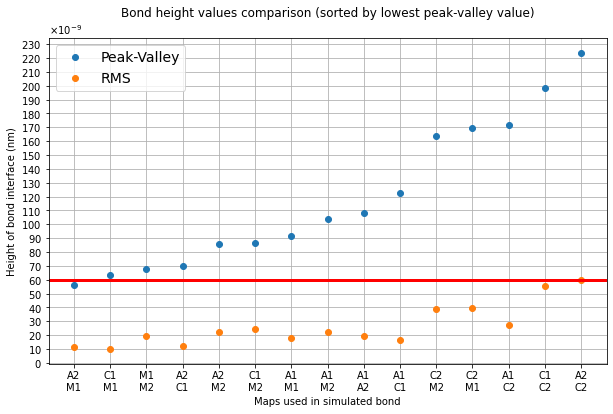

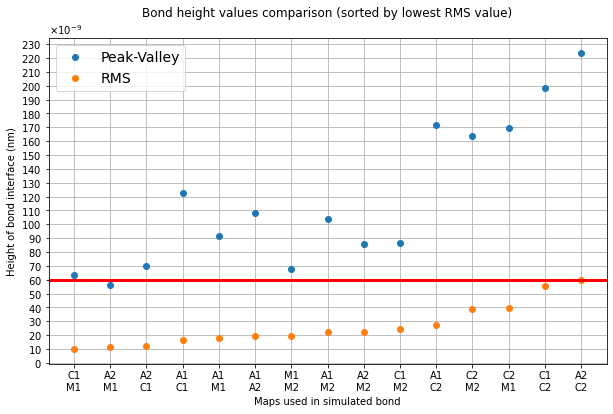

In [12]:
comparebonds(zmaps, sort="both", plot=True)

In [115]:
#applying crops to maps, to compare with edge defects removed
zcropped = []
radius = 32

for i in range(len(zmaps)):
    zmaps[i].crop(radius)  # - note: will change the zmap object, adjust radius back to zero here (or create separate objects)
    zmaps[i].rotateflat()  # - could change crop() to call this automatically
    croppedmap = copy.copy(zmaps[i])  # - to maintain distinct objects (cropped vs uncropped), but share the attributes
    zcropped.append(croppedmap)
    
    #reset original maps
    zmaps[i].crop()
    zmaps[i].rotateflat()

Sample Bonds sorted by lowest peak-to-valley height:

1 -  C1.txt M1.txt
Peak-to-valley Height: 22.1 nm
RMS Height: 3.7 nm


2 -  A2.txt C1.txt
Peak-to-valley Height: 26.9 nm
RMS Height: 6.3 nm


3 -  A2.txt M1.txt
Peak-to-valley Height: 30.0 nm
RMS Height: 6.3 nm


4 -  C2.txt M2.txt
Peak-to-valley Height: 37.7 nm
RMS Height: 8.1 nm


5 -  M1.txt M2.txt
Peak-to-valley Height: 40.9 nm
RMS Height: 14.7 nm


6 -  C1.txt M2.txt
Peak-to-valley Height: 41.1 nm
RMS Height: 15.0 nm


7 -  A2.txt M2.txt
Peak-to-valley Height: 43.0 nm
RMS Height: 17.1 nm


8 -  C2.txt M1.txt
Peak-to-valley Height: 43.9 nm
RMS Height: 12.2 nm


9 -  A2.txt C2.txt
Peak-to-valley Height: 47.7 nm
RMS Height: 15.0 nm


10 -  C1.txt C2.txt
Peak-to-valley Height: 49.5 nm
RMS Height: 18.3 nm


11 -  A1.txt M2.txt
Peak-to-valley Height: 62.4 nm
RMS Height: 15.1 nm


12 -  A1.txt M1.txt
Peak-to-valley Height: 62.7 nm
RMS Height: 17.7 nm


13 -  A1.txt C1.txt
Peak-to-valley Height: 67.2 nm
RMS Height: 18.5 nm


14 -  A1.t

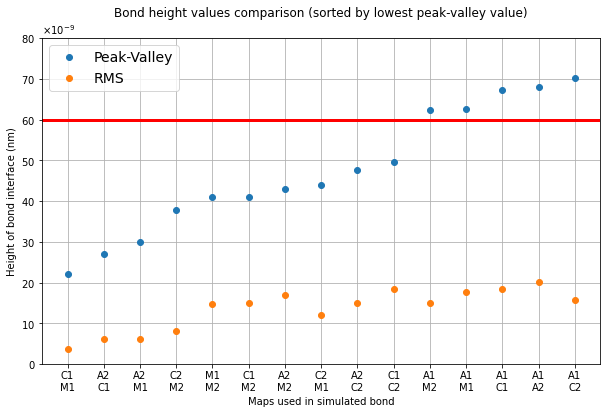

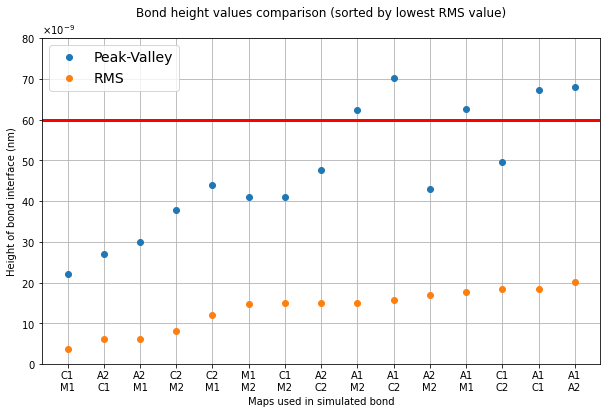

In [116]:
comparebonds(zcropped, sort="both", plot=True)

/local/environments/gw/gw-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  # This is added back by InteractiveShellApp.init_path()


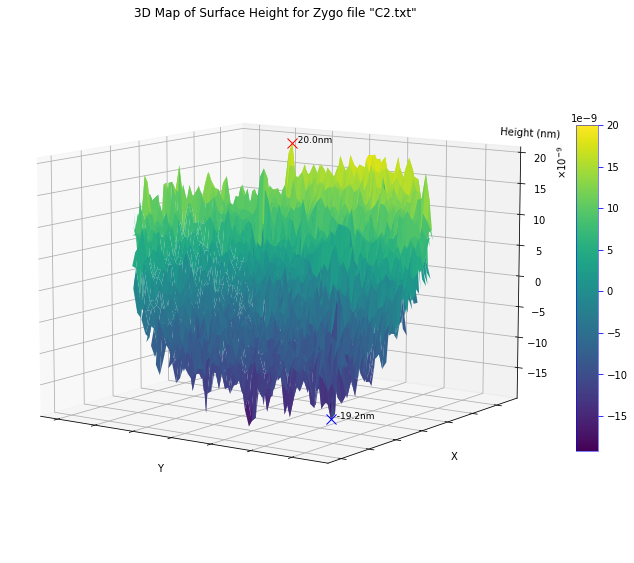

In [15]:
i = 3
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection="3d")
x,y = np.indices(zcropped[i].heights.shape)
peak,valley = np.nanmax(zcropped[i].heights), np.nanmin(zcropped[i].heights)  # - cropped maps, not updated overall pv value
peakxy, valleyxy = np.where(zcropped[i].heights == peak), np.where(zcropped[i].heights == valley)
# ax.set_zlim(zmaps[i].valley, zmaps[i].peak)
ax.set_zlim(valley,peak)
current_cmap = copy.copy(cm.get_cmap("viridis"))

p = ax.plot_surface(x,y, zcropped[i].heights, vmin=valley, vmax=peak, cmap=current_cmap, ccount=10000, rcount=10000)
ax.plot3D(*valleyxy, valley, "bx", zorder=10, ms=10)
ax.plot3D(*peakxy, peak, "rx", zorder=10, ms=10)
ax.text(valleyxy[0][0],valleyxy[1][0],valley, "  {0:.1f}nm".format(valley * 1e9), zorder=10, size=9)
ax.text(peakxy[0][0],peakxy[1][0],peak, "  {0:.1f}nm".format(peak * 1e9), zorder=10, size=9)
# cblabels = [valley, 0, peak]
# cbax = fig.add_axes([0.3,0.6,0.2,0.5])
cb = plt.colorbar(p, pad=0.05, shrink=0.5, aspect=15)#, ticks=[valley, 0, peak])
cb.ax.tick_params(color="b", length=5)
cb.formatter.set_scientific(True)
cb.formatter.set_powerlimits((-9,-9))
cb.outline.set_edgecolor("b")
cb.outline.set_linewidth(0.5)
ax.set_title("3D Map of Surface Height for Zygo file \"{}\"".format(zmaps[i].filename), pad=-1000)
plt.ticklabel_format(axis="z", style="sci", scilimits=(-9,-9), useMathText=True)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
plt.xlabel("Y")  # - since matrix i,j are used for axes, spatial x,y should swap
plt.ylabel("X")
ax.set_zlabel("Height (nm)" + "\n"*24)
ax.zaxis._axinfo["label"]["ha"] = "right"
ax.zaxis.set_rotate_label(False)
ax.zaxis.label.set_rotation("-3")
# ax.zaxis.set_label_coords(0,0)

ax.view_init(elev=10, azim=-55)
# plt.savefig("3Dplot_C2.png")
plt.show()